In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

In [2]:
# plasticc data files
metadata_file = 'plasticc_data/plasticc_train_metadata.csv'
data_file = 'plasticc_data/plasticc_train_lightcurves.csv'
param_file = 'plasticc_data/plasticc_modelpar_090_SNIa.csv'

In [3]:
# pull out relevant metadata for the snIa
metadata = Table.read(metadata_file)
snIa_id = 90
idx = (metadata['true_target'] == snIa_id)
metadata = metadata[idx]['object_id', 'true_z', 'true_distmod', 'true_peakmjd']

# get salt2 parameters used to generate data
metadata['stretch'] = np.zeros(len(metadata))
metadata['salt2_mb'] = np.zeros(len(metadata))
params = Table.read(param_file)
for obj in metadata:
    idx = (params['object_id'] == obj['object_id'])
    # calculate stretch from x1
    # formula from https://arxiv.org/pdf/astro-ph/0701828.pdf page 5
    x1 = params[idx]['salt2_x1'][0]
    stretch = 0.98 + 0.091*x1 + 0.003*x1**2 - 0.00075*x1**3
    obj['stretch'] = round(stretch, 4)
    # get bolometric mag in case you want to use this to normalize
    obj['salt2_mb'] = params[idx]['salt2_mb'][0]
    
metadata

object_id,true_z,true_distmod,true_peakmjd,stretch,salt2_mb
int64,float64,float64,float64,float64,float64
745,0.301,40.969,60130.453,0.9791,21.5499
1124,0.193,39.866,60452.641,0.9107,20.5393
1598,0.136,39.03,60628.816,1.0704,19.4699
1920,0.311,41.038,59996.625,1.0701,21.5215
2072,0.15,39.268,59652.648,0.9163,20.2494
2330,0.454,42.011,60385.449,1.0956,22.5404
4389,0.234,40.337,60277.695,1.0592,20.76
4595,0.592,42.703,60218.465,1.0697,22.6502
4819,0.303,40.985,60558.34,1.054,21.3699


In [134]:
# load the snIa data
data = Table.read(data_file)

# keep fluxes whose object_id match one of the snIa in the metadata
# keep only those with detected_bool == 1
idx = (np.in1d(data['object_id'], metadata['object_id'])) & (data['detected_bool'] == 1)
data = data[idx]

# convert passband values to human-readable
passband_dict = {0:'lsstu', 1:'lsstg', 2:'lsstr', 3:'lssti', 4:'lsstz', 5:'lssty'}
data['passband'] = np.vectorize(passband_dict.get)(data['passband'])

# mjd --> corrected rest frame phase
data.rename_column('mjd', 'phase')
for obj in data:
    idx = (metadata['object_id'] == obj['object_id'])
    # convert to phase
    peak_mjd = metadata[idx]['true_peakmjd']
    obj['phase'] = obj['phase'] - peak_mjd
    # correct for time dilation
    redshift = metadata[idx]['true_z']
    obj['phase'] /= (1 + redshift)
    # standardize w.r.t. stretch
    stretch = metadata[idx]['stretch']
    #obj['phase'] /= stretch
    # round to make the table more readable
    obj['phase'] = round(obj['phase'], 6)

In [135]:
data

object_id,phase,passband,flux,flux_err,detected_bool
int64,float64,str5,float64,float64,int64
745,-3.87671,lsstr,220.795212,1.492162,1
745,-3.870792,lsstg,192.244293,1.432564,1
745,-3.864873,lssti,203.250702,1.862,1
745,-3.856495,lsstz,183.633118,2.818825,1
745,-3.8495,lssty,141.51329,11.663839,1
745,7.522905,lsstu,18.014029,1.878526,1
745,10.587394,lsstu,13.940004,1.963381,1
745,17.547886,lsstr,85.117493,1.062634,1
745,17.553805,lsstg,33.86031,0.962349,1


In [136]:
# normalize magnitudes
# there are two options for the method
# comment out the one you don't want to use

normed_data = data.copy()

# using redshit and distance
for obj in normed_data:
    idx = (metadata['object_id'] == obj['object_id'])
    
    # correct for distance
    dist_mod = metadata[idx]['true_distmod']
    obj['flux'] *= 10**(2/5 * dist_mod)
    obj['flux_err'] *= 10**(2/5 * dist_mod)
    
    # correct for redshift
    #redshift = metadata[idx]['true_z']
    #obj['flux'] *= (1 + redshift)**3
    #obj['flux_err'] *= (1 + redshift)**3
    
"""# using the bolometric magnitude from salt2
for obj in normed_data:
    idx = (metadata['object_id'] == obj['object_id'])
    mb = metadata[idx]['salt2_mb']
    fb = 10 ** (-2/5 * mb)
    obj['flux'] /= fb"""

;

''

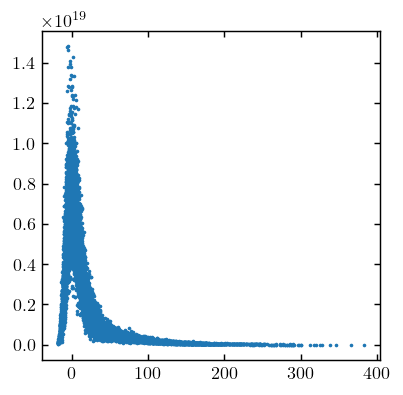

In [137]:
idx = (normed_data['passband'] == 'lsstr')
plt.scatter(normed_data[idx]['phase'], normed_data[idx]['flux'], s=1)

In [138]:
from classes import Bandpasses

In [139]:
bandpasses = Bandpasses()

In [140]:
color_dict = {'lsstu':'C4', 'lsstg':'C2', 'lsstr':'C3', 'lssti':'C1', 'lsstz':'gray', 'lssty':'k'}

wavelen = []
fluxes = []
colors = []

for row in normed_data:
    if row['phase'] > -0.2 and row['phase'] < 0.2:
        idx = (metadata['object_id'] == row['object_id'])
        # wavelen
        redshift = metadata[idx]['true_z']
        band = row['passband']
        wavelen.append(bandpasses.mean_wavelen(band)/(1 + redshift))
        # flux
        fluxes.append(row['flux'])
        # color
        color = color_dict[band]
        colors.append(color)
        

(-1e+18, 1.8e+19)

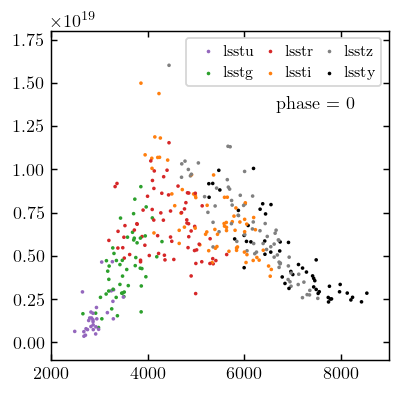

In [141]:
fig,ax = plt.subplots()

plt.scatter(wavelen, fluxes, c=colors)

for name,c in color_dict.items():
    plt.scatter([-10], [1e19], c=c, label=name)
plt.legend(ncol=3, fontsize='small', loc='upper right', columnspacing=0, handletextpad=0)
ax.text(0.9, 0.8, f'phase = 0', transform=ax.transAxes, ha='right', va='top')
plt.xlim(2000,9000)
plt.ylim(-1e18,1.8e19)

In [146]:
plt.errorbar?

Signature:
plt.errorbar(
    x,
    y,
    yerr=None,
    xerr=None,
    fmt='',
    ecolor=None,
    elinewidth=None,
    capsize=None,
    barsabove=False,
    lolims=False,
    uplims=False,
    xlolims=False,
    xuplims=False,
    errorevery=1,
    capthick=None,
    *,
    data=None,
    **kwargs,
)
Docstring:
Plot y versus x as lines and/or markers with attached errorbars.

*x*, *y* define the data locations, *xerr*, *yerr* define the errorbar
sizes. By default, this draws the data markers/lines as well the
errorbars. Use fmt='none' to draw errorbars without any data markers.

Parameters
----------
x, y : scalar or array-like
    The data positions.

xerr, yerr : scalar or array-like, shape(N,) or shape(2,N), optional
    The errorbar sizes:

    - scalar: Symmetric +/- values for all data points.
    - shape(N,): Symmetric +/-values for each data point.
    - shape(2,N): Separate - and + values for each bar. First row
        contains the lower errors, the second row contains t

(-1e+18, 1.8e+19)

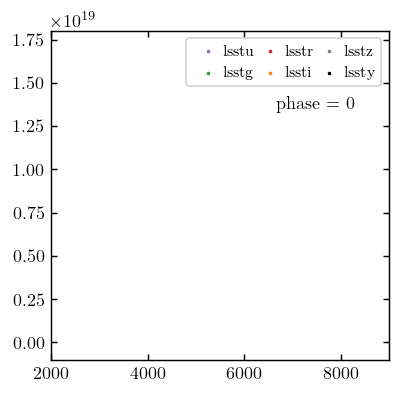

In [149]:
fig,ax = plt.subplots()

plt.errorbar(wavelen, fluxes, ecolor=colors, lw=0)

for name,c in color_dict.items():
    plt.scatter([-10], [1e19], c=c, label=name)
plt.legend(ncol=3, fontsize='small', loc='upper right', columnspacing=0, handletextpad=0)
ax.text(0.9, 0.8, f'phase = 0', transform=ax.transAxes, ha='right', va='top')
plt.xlim(2000,9000)
plt.ylim(-1e18,1.8e19)